In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from system import *

In [2]:
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx("float64")

%load_ext autoreload
%autoreload 2

In [3]:
class Ansatz(tf.keras.Model):
    def __init__(self, nodes, hidden_units):
        super().__init__()
        
        self.Layers = []
        for node in nodes:
            self.Layers.append(tf.keras.layers.Dense(node))
        
        self.out = tf.keras.layers.Dense(1)
        
        self.w = tf.keras.layers.Dense(hidden_units)
        self.hidden_initial = tf.Variable(tf.ones((1, hidden_units), dtype=tf.dtypes.float64))
    
    
    def call(self, x):
        y = tf.concat((self.hidden, x), axis=1)
        for layer in self.Layers:
            y = tf.math.tanh(layer(y))

        return tf.math.exp(self.out(y))

    
    def rnn_forward(self, x):
        x = tf.concat((self.hidden, x), axis=1)
        self.hidden = tf.tanh(self.w(x))
    
    
    def hidden_reset(self, batch_size):
        self.hidden = tf.repeat(self.hidden_initial, batch_size, axis=0)
        
        
    
@tf.function
def loss(system, x):
    batch_size = x.shape[0]
    num_part = system.num_part
    dim = system.dim
    
    _x = tf.unstack(x, axis=1)
    _x_ = [tf.expand_dims(tmp, axis = 1) for tmp in _x]
    _x2 = tf.transpose(tf.stack(_x_))[0]
    
    psi = 1
    system.Ansatz.hidden_reset(batch_size)
    for i in range(num_part):
        psi *= system.Ansatz(_x2[:,i*dim:(i+1)*dim])
        system.Ansatz.rnn_forward(_x2[:,i*dim:(i+1)*dim])
    
    d_psi = [tf.squeeze(tf.gradients(psi, tmp)) for tmp in _x]
    d2_psi = 0
    for ii in range(num_part*dim):
        d2_psi += tf.stack(tf.gradients(d_psi[ii], _x_[ii]))[0]
    
    lap = 1/psi*(d2_psi)
    
    E_L = -0.5*lap + system.External(x) + system.Internal(x, num_part, dim)

    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(system, x):
    with tf.GradientTape() as tape:
        E, loss_value = loss(system, x)

    return E, tape.gradient(loss_value, system.Ansatz.trainable_variables)


def train(system, num_epochs, batch_size, optimizer, verbose = True):
    energy = []
    
    for epoch in tqdm(range(num_epochs)):
        x = []
        
        system.Ansatz.hidden_reset(batch_size)
        for i in range(system.num_part):
            x.append(system.Sampler(batch_size)[0])
            system.Ansatz.rnn_forward(x[-1])

        x = tf.concat(x, axis=1)
        
        E, gradients = grad(system, x)
        energy.append(E)

        optimizer.apply_gradients(zip(gradients, system.Ansatz.trainable_variables))
        
        if verbose:
            if epoch%100 == 0: 
                print(f"epoch: {epoch}, Energy: {E}")
    
    return energy  

In [4]:
tf.random.set_seed(42)
np.random.seed(42)


nodes = ((64, 32))
hidden_units = 10
ansatz = Ansatz(nodes, hidden_units)


external = HarmonicOsc(0.28)
internal = Coulomb(1, 0)
sampler = Metropolis(1, 20)

system = System(num_part = 2,
                 dim = 3,
                 Ansatz=ansatz,
                 External=external,
                 Internal=internal,
                 Sampler=sampler
                 )

optimizer = tf.keras.optimizers.Adam(0.01)
energy = []

In [5]:
num_epochs = 2000
batch_size = 3000

energy = train(system, num_epochs, batch_size, optimizer, verbose = True)

epoch: 0, Energy: 1.9116393420658806
epoch: 100, Energy: 1.222292373773985
epoch: 200, Energy: 1.2113842705122058
epoch: 300, Energy: 1.2062154543357686
epoch: 400, Energy: 1.204714511508954
epoch: 500, Energy: 1.204543117744496
epoch: 600, Energy: 1.2030081742746852
epoch: 700, Energy: 1.2054953020918593
epoch: 800, Energy: 1.2041967196287982
epoch: 900, Energy: 1.2012101183242048
epoch: 1000, Energy: 1.2046947279235933
epoch: 1100, Energy: 1.2035546131219166
epoch: 1200, Energy: 1.2032797528379124
epoch: 1300, Energy: 1.2065547684900884
epoch: 1400, Energy: 1.2019559281488512
epoch: 1500, Energy: 1.2001580867974997



KeyboardInterrupt: 

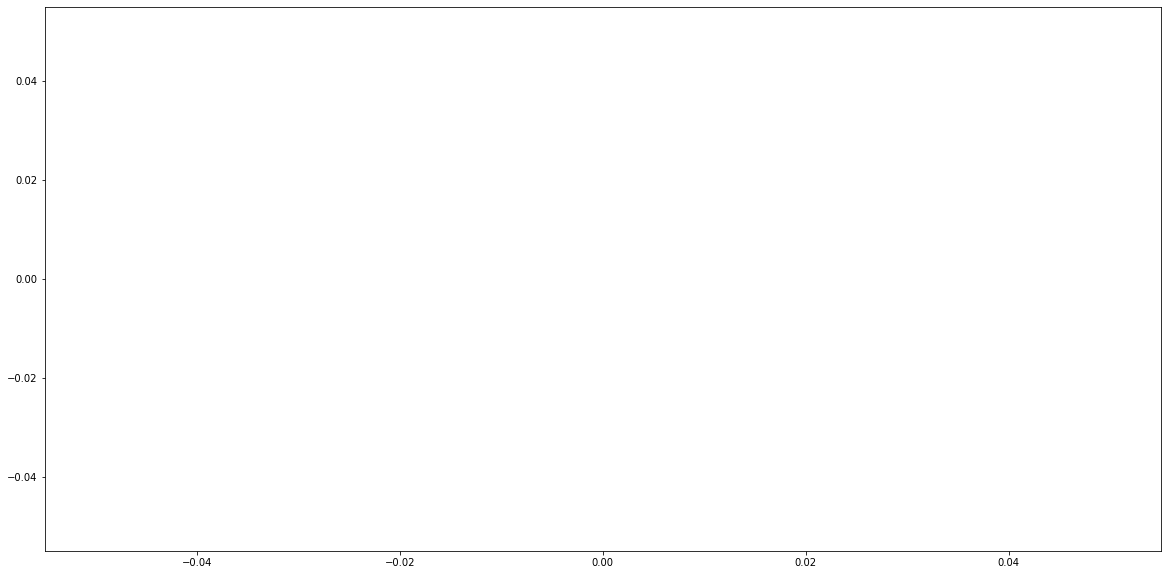

In [7]:
plt.figure(figsize=(20,10))
plt.plot(energy)
#plt.ylim([5, 7])
plt.show()

In [ ]:
def f(x, y):
    N = 300
    x_lin = np.linspace(-4, 4, N)
    dx = x_lin[1] - x_lin[0]
    tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

    x1 = tf.convert_to_tensor(x*np.ones((N,1)), dtype=tf.dtypes.float64)
    x2 = tf.convert_to_tensor(y*np.ones((N,1)), dtype=tf.dtypes.float64)

    model.hidden_reset(N)
    psi1 = model(tf_x_lin).numpy()[:, 0]
    
    model.rnn_forward(x1)
    psi2 = model(tf_x_lin).numpy()[:, 0]
    
    model.rnn_forward(x2)
    psi3 = model(tf_x_lin).numpy()[:, 0]

    plt.plot(x_lin, 1/dx*psi1**2/np.sum(psi1**2))
    plt.plot(x_lin, 1/dx*psi2**2/np.sum(psi2**2))
    plt.plot(x_lin, 1/dx*psi3**2/np.sum(psi3**2))
    
    plt.plot(x, 0.01, "bo")
    plt.plot(y, 0.01, "ro")
    plt.ylim(0, 0.8)
    plt.show()

interact(f, x=(-4.0, 4., 0.1), y=(-4.0, 4., 0.1))

#### Estimate energy

In [8]:
N = 1000000
system.Ansatz.hidden_reset(N)
x1, _ = system.Sampler(N)
system.Ansatz.rnn_forward(x1)
x2, _ = system.Sampler(N)
x = tf.concat((x1, x2), axis=1)
E, _ = loss(system, x)
print(E)

tf.Tensor(1.203119407187489, shape=(), dtype=float64)
